In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.ensemble import IsolationForest
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
#Proprocessing

df = pd.read_csv("TEST_Trader_Quant_dataset.csv")

#Make sure everything is numeric
df = df.apply(pd.to_numeric, errors="coerce")

#Assume first column is time and sorting according to columnn no 1 in ascending order.
time_col = df.columns[0]
df = df.sort_values(by=time_col, ascending=True).reset_index(drop=True)

#Separate time and features
time = df[time_col].copy()
X = df.drop(columns=[time_col]).copy()

#Drop 0 variance columns
variances = X.var(axis=0, ddof=0)
X = X.loc[:, variances > 1e-12]

#Standardizing each feature to mean 0 and standard deviation 1.
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
scaler = StandardScaler(with_mean=True, with_std=True)
X_scaled = scaler.fit_transform(X)

#Save the preprocessed dataset
df_preprocessed = pd.DataFrame(X_scaled, columns=X.columns)
df_preprocessed.insert(0, "time", time.values)

output_path = "preprocessed_dataset.csv"
df_preprocessed.to_csv(output_path, index=False)

In [3]:
#PCA analysis. https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

df = pd.read_csv("preprocessed_dataset.csv")

time = df["time"]
X_scaled = df.drop(columns=["time"]).values

pca = PCA()
scores_all = pca.fit_transform(X_scaled)

#Explained variance summary (90%)
explained_ratio = pca.explained_variance_ratio_
cum_ratio = np.cumsum(explained_ratio)

#Number of PCA needed to reach 90% variance
k90 = int(np.searchsorted(cum_ratio, 0.90) + 1)

In [4]:
#Create PCA object keeping components for 90% 
pca32 = PCA(n_components=k90)

#Fit PCA on the data and transform it
X_pca32 = pca32.fit_transform(X_scaled)

# Turn into DataFrame with column names
df_pca32 = pd.DataFrame(X_pca32, columns=[f"PC{i+1}" for i in range(k90)])
df_pca32.insert(0, "time", time.values)

# Save
df_pca32.to_csv("pca32_dataset.csv", index=False)

In [5]:
#Isolation Forest.
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html

X32 = df_pca32.drop(columns=["time"]).to_numpy()

iso = IsolationForest(contamination=0.02, random_state=0)
anoms = iso.fit_predict(X32)  # -1 = anomaly, 1 = normal

df_pca32["anomaly"] = (anoms == -1).astype(int)
n = len(df_pca32)
n_anom = int(df_pca32["anomaly"].sum())

print("Anomalies detected:", n_anom)
print(f"Anomalies: {n_anom}/{n} = {n_anom/n:.2%}")

Anomalies detected: 174
Anomalies: 174/8688 = 2.00%


In [6]:
#KMeans Clustering. https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html
# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html

PC = [c for c in df_pca32.columns if c.startswith("PC")]
X  =  df_pca32.drop(columns=["time"]).to_numpy()
Xz = StandardScaler().fit_transform(X)

best=None
for k in range(2,9):
    km = KMeans(n_clusters=k, n_init=20, random_state=0).fit(Xz)
    s  = silhouette_score(Xz, km.labels_)
    best = (s,k,km) if best is None or s>best[0] else best

sil,k,km = best
df_pca32["cluster_std"] = km.labels_
print(f"Standardized KMeans → K={k}, silhouette={sil:.3f}")

#Anomalies by cluster
print(df_pca32.groupby("cluster_std")["anomaly"].agg(['mean','sum','count']))

Standardized KMeans → K=2, silhouette=0.756
             mean  sum  count
cluster_std                  
0             1.0  174    174
1             0.0    0   8514


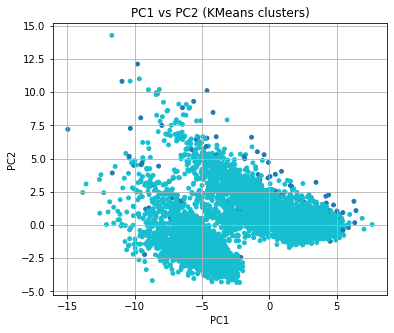

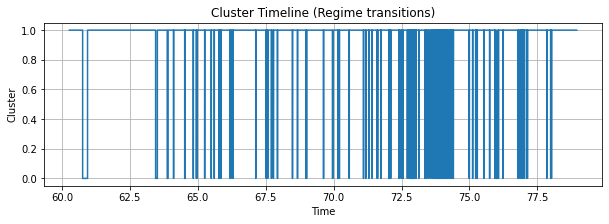

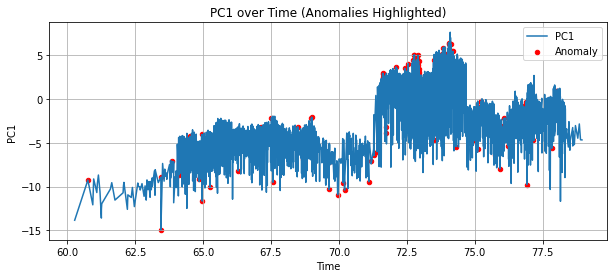


Mean PC values by cluster:
cluster_std         0         1
PC1         -0.472157  0.009649
PC2          1.779279 -0.036363
PC3         -2.330364  0.047625
PC4          0.339126 -0.006931
PC5          1.688506 -0.034508
PC6         -0.116060  0.002372
PC7          0.954096 -0.019499
PC8          0.709712 -0.014504
PC9          1.967606 -0.040212
PC10        -1.550343  0.031684


In [7]:
#PC1 vs PC2 colored by KMeans clusters
plt.figure(figsize=(6,5))
plt.scatter(df_pca32["PC1"], df_pca32["PC2"], 
            c=df_pca32["cluster_std"], cmap="tab10", s=15)
plt.title("PC1 vs PC2 (KMeans clusters)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.grid(True)
plt.show()

#Cluster timeline over time
plt.figure(figsize=(10,3))
plt.step(df_pca32["time"], df_pca32["cluster_std"], where="post")
plt.title("Cluster Timeline (Regime transitions)")
plt.xlabel("Time"); plt.ylabel("Cluster")
plt.grid(True)
plt.show()

#PC1 time series with anomaly highlights
plt.figure(figsize=(10,4))
plt.plot(df_pca32["time"], df_pca32["PC1"], label="PC1")
plt.scatter(df_pca32.loc[df_pca32["anomaly"]==1, "time"],
            df_pca32.loc[df_pca32["anomaly"]==1, "PC1"],
            color="red", s=20, label="Anomaly")
plt.title("PC1 over Time (Anomalies Highlighted)")
plt.xlabel("Time"); plt.ylabel("PC1")
plt.legend(); plt.grid(True)
plt.show()

#Mean PC values per cluster (summary table)
pc_means = df_pca32.groupby("cluster_std")[[c for c in df_pca32.columns if c.startswith("PC")]].mean().T
print("\nMean PC values by cluster:")
print(pc_means.head(10))

In [8]:
df_pre = df_preprocessed.copy()
time = df_pre.iloc[:, 0].values
X_orig_df = df_pre.drop(columns=[df_pre.columns[0]]).copy()
feat_names = X_orig_df.columns.tolist()
    

#Attach time 
df_features = pd.DataFrame(X_orig_df.values, columns=feat_names)
df_features.insert(0, "time", df_pca32["time"].values)



In [9]:
Xf = df_features.drop(columns=["time"]).copy()

#Correlation matrices
corr_pearson  = Xf.corr(method="pearson")
corr_spearman = Xf.corr(method="spearman")

#Helper: collect top correlation pairs
def top_abs_pairs_simple(corr_df, top_n=30):
    """
    corr_df: A correlation matrix where rows and columns are feature names.
    top_n: Number of top absolute correlation pairs to return.
    """
    
    pairs = []
    cols = list(corr_df.columns)
    for i in range(len(cols)):
        for j in range(i+1, len(cols)): 
            f1 = cols[i]
            f2 = cols[j]
            val = corr_df.loc[f1, f2]
            pairs.append([f1, f2, float(val), float(abs(val))])
    pairs.sort(key=lambda x: x[3], reverse=True)
    pairs = pairs[:top_n]
    return pd.DataFrame(pairs, columns=["feature_a", "feature_b", "corr", "|corr|"])

#Get top 30 for Pearson and Spearman
top_pairs_pearson  = top_abs_pairs_simple(corr_pearson,  top_n=30)
top_pairs_spearman = top_abs_pairs_simple(corr_spearman, top_n=30)

print("Top Pearson pairs (by absolute correlation):")
print(top_pairs_pearson.round(3).to_string(index=False))

print("\nTop Spearman pairs (by absolute correlation):")
print(top_pairs_spearman.round(3).to_string(index=False))



Top Pearson pairs (by absolute correlation):
feature_a feature_b  corr  |corr|
       20        29 1.000   1.000
       11        30 0.975   0.975
       11        48 0.973   0.973
       39        48 0.972   0.972
       11        39 0.952   0.952
       30        48 0.950   0.950
       30        39 0.946   0.946
       34        35 0.849   0.849
       33        34 0.832   0.832
       34        36 0.830   0.830
       36        37 0.827   0.827
       33        36 0.826   0.826
       35        36 0.823   0.823
       37        38 0.822   0.822
       33        35 0.818   0.818
       33        37 0.817   0.817
       37        46 0.816   0.816
       33        38 0.815   0.815
       37        45 0.806   0.806
       36        38 0.806   0.806
       34        42 0.804   0.804
       34        37 0.799   0.799
       33        46 0.798   0.798
       34        43 0.798   0.798
       33        45 0.794   0.794
       35        42 0.791   0.791
       45        46 0.791   0.791
   

In [10]:
from sklearn.cluster import AgglomerativeClustering
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html

corr_abs = corr_pearson.abs()

# distance = 1 - |corr|
dist = 1.0 - corr_abs
np.fill_diagonal(dist.values, 0.0)

#Cluster
model = AgglomerativeClustering(
    n_clusters=None,              
    distance_threshold=0.3,      
    linkage="average",
    metric="precomputed"         
)
labels = model.fit_predict(dist.values)

cluster_df = pd.DataFrame({
    "feature": corr_abs.columns.astype(str),
    "cluster_id": labels
})

#Sizes
sizes = cluster_df["cluster_id"].value_counts().sort_values(ascending=False)
print("cluster sizes:")
print(sizes)

#Show clusters with at least 2 members
print("\nclusters with >= 2 features:")
for cid in sizes.index:
    members = cluster_df.loc[cluster_df["cluster_id"] == cid, "feature"].tolist()
    if len(members) >= 2:
        print(f"cluster {cid} (n={len(members)}): {members}")


cluster sizes:
cluster_id
0     12
7      4
1      2
3      2
5      2
2      2
23     1
18     1
10     1
27     1
29     1
9      1
28     1
35     1
22     1
26     1
33     1
30     1
36     1
21     1
31     1
8      1
32     1
17     1
13     1
25     1
19     1
15     1
14     1
6      1
11     1
34     1
4      1
12     1
24     1
20     1
16     1
Name: count, dtype: int64

clusters with >= 2 features:
cluster 0 (n=12): ['33', '34', '35', '36', '37', '38', '42', '43', '44', '45', '46', '47']
cluster 7 (n=4): ['11', '30', '39', '48']
cluster 1 (n=2): ['2', '3']
cluster 3 (n=2): ['40', '41']
cluster 5 (n=2): ['20', '29']
cluster 2 (n=2): ['21', '22']


In [11]:
#Standardize features (z-score)
Xz = (Xf - Xf.mean()) / (Xf.std(ddof=0) + 1e-12)

#CUSUM analysis
def cusum_changes(x, thr=8.0, gap=30):
    """
    x   : a single feature time series (numpy array)
    thr : threshold that determines how big a shift must be to count as a change
    gap : minimum number of data points between detections
    """
    
    s_pos = s_neg = 0.0
    last = -gap
    out = []
    for i in range(1, len(x)):
        v = float(x[i])
        s_pos = max(0.0, s_pos + v)
        s_neg = min(0.0, s_neg + v)
        if (s_pos > thr or s_neg < -thr) and (i - last >= gap):
            out.append(i); s_pos = 0.0; s_neg = 0.0; last = i
    return out

thr = 8.0
gap = max(10, int(len(Xz) * 0.01))
t = df_features["time"].values

rows = []
for c in Xz.columns:
    for i in cusum_changes(Xz[c].values, thr, gap):
        rows.append({"feature": str(c), "time": float(t[i])})

cp_table = pd.DataFrame(rows).sort_values("time")

"""
Table Description:

feature: Index of the feature that changed.

time: The time value when the change was detected.

Also the total amount of such changes detected is also calculated.
""" 
print(len(cp_table))
print(cp_table.head(20).to_string(index=False))

5163
feature     time
      5 60.76325
     30 60.94425
     31 60.94425
     11 60.97650
     48 60.97650
     12 60.97650
     32 60.97650
     39 60.97650
     33 61.09225
     25 61.09225
     37 61.11175
     13 61.11175
     42 61.11175
     45 61.11175
     36 61.11175
     38 61.11175
     40 61.11175
     34 61.11175
     22 61.11175
     35 61.11175


In [12]:
#Computing system-wide change density and top hotspots. https://numpy.org/doc/stable/reference/generated/numpy.histogram.html

#Choosing bin width
bin_width = 0.2
t_min, t_max = float(df_features["time"].min()), float(df_features["time"].max())
bins = np.arange(t_min, t_max + bin_width, bin_width)
counts, edges = np.histogram(cp_table["time"].values, bins=bins)
centers = (edges[:-1] + edges[1:]) / 2.0

#Top hotspots
top_idx = np.argsort(counts)[::-1][:10]
hotspot_list = [{"time_center": float(centers[i]), "features_changed": int(counts[i])} for i in top_idx]
hotspot_df = pd.DataFrame(hotspot_list).sort_values("features_changed", ascending=False)
print("Top hotspots (time_center, features_changed):")
print(hotspot_df.head(10).to_string(index=False))


Top hotspots (time_center, features_changed):
 time_center  features_changed
    73.97775               546
    74.17775               533
    73.77775               441
    74.37775               278
    73.57775               221
    72.37775               132
    65.77775               123
    76.97775               113
    72.97775               110
    71.97775               109


In [1]:
import subprocess
subprocess.run(["jupyter", "nbconvert", "--to", "html", "Data Analysis.ipynb", "--output", "Yagiz_Bayrak.html"], check=True)


[NbConvertApp] Converting notebook Data Analysis.ipynb to html
[NbConvertApp] Writing 751686 bytes to Yagiz_Bayrak.html


CompletedProcess(args=['jupyter', 'nbconvert', '--to', 'html', 'Data Analysis.ipynb', '--output', 'Yagiz_Bayrak.html'], returncode=0)